In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from operator import attrgetter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from lifetimes import ModifiedBetaGeoFitter, BetaGeoFitter

# 1. Carregando Dados 

In [28]:
df = pd.read_csv('../dataset/transaction_new.csv')
df['created_at'] = pd.to_datetime(df['created_at'], format="%Y-%m-%d").dt.tz_localize(None).dt.normalize()
df

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254580,2021-09-21,25121,66f02fa4-c62e-497a-8b6e-be239009b50a,484eecde-9f4a-42de-a8df-7ce6668101f4,Debit Card,Failed,0,NaN,0,2021-09-27T00:43:40.992167Z,-6.869535,111.077145,226820,30642,2,113410
1254581,2021-12-09,34829,ccde6b83-ee42-4cce-b2cd-976574886eac,954e1211-4d45-4d0b-ba84-53e80119592c,OVO,Success,5010,AZ2022,10000,2021-12-12T07:52:44.803822Z,-8.677264,115.176947,359203,19394,1,354213
1254582,2021-12-11,99645,5bcd3434-1dc6-44bb-ae63-fd19714cbd6c,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,Credit Card,Success,2181,WEEKENDSERU,5000,2021-12-12T13:28:22.848703Z,-6.185498,106.831093,1158159,13079,4,288835
1254583,2019-12-18,87319,af7f291a-b01b-4bfd-89a9-237b16368b15,bb6e5426-a3f3-426a-b99d-79173eaa234b,Credit Card,Success,4503,AZ2022,0,2019-12-23T22:56:46.831720Z,-7.155977,110.891858,184143,11312,1,188646


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   created_at              1254585 non-null  datetime64[ns]
 1   customer_id             1254585 non-null  int64         
 2   booking_id              1254585 non-null  object        
 3   session_id              1254585 non-null  object        
 4   payment_method          1254585 non-null  object        
 5   payment_status          1254585 non-null  object        
 6   promo_amount            1254585 non-null  int64         
 7   promo_code              481139 non-null   object        
 8   shipment_fee            1254585 non-null  int64         
 9   shipment_date_limit     1254585 non-null  object        
 10  shipment_location_lat   1254585 non-null  float64       
 11  shipment_location_long  1254585 non-null  float64       
 12  total_amount  

In [23]:
df['payment_status'].value_counts()

Success    1201035
Failed       53550
Name: payment_status, dtype: int64

In [24]:
df['customer_id'].value_counts()

43202    807
29496    749
82237    716
10167    693
69740    673
        ... 
2934       1
4363       1
52112      1
92794      1
58180      1
Name: customer_id, Length: 50705, dtype: int64

# 1. Análise Janela de Tempo

In [32]:
df_ret = df[df['payment_status'] == 'Success']
df_ret = df_ret[['created_at', 'customer_id']]
df_ret = df_ret.sort_values(['created_at'])
df_ret.drop_duplicates(inplace=True)
df_ret

,created_at,customer_id
1254461,2016-06-30,74089
1254460,2016-07-01,73773
1201589,2016-07-01,6183
1201721,2016-07-01,16228
1227446,2016-07-02,37770
...,...,...
972414,2022-07-31,98145
972410,2022-07-31,25085
119942,2022-07-31,95552
582270,2022-07-31,10279


In [33]:
df_ret['next_date'] = df_ret.groupby('customer_id')['created_at'].shift(-1)
df_ret.fillna({'next_date':pd.to_datetime('2022-08-01', format="%Y-%m-%d")}, inplace=True)
df_ret['lag_date'] = (df_ret['next_date'] - df_ret['created_at']).dt.days
df_ret

C:\Users\Carlos\AppData\Local\Temp\ipykernel_9036\393517833.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ret.fillna({'next_date':pd.to_datetime('2022-08-01', format="%Y-%m-%d")}, inplace=True)


,created_at,customer_id,next_date,lag_date
1254461,2016-06-30,74089,2017-09-18,445
1254460,2016-07-01,73773,2022-08-01,2222
1201589,2016-07-01,6183,2016-07-26,25
1201721,2016-07-01,16228,2017-09-18,444
1227446,2016-07-02,37770,2017-03-06,247
...,...,...,...,...
972414,2022-07-31,98145,2022-08-01,1
972410,2022-07-31,25085,2022-08-01,1
119942,2022-07-31,95552,2022-08-01,1
582270,2022-07-31,10279,2022-08-01,1


In [34]:
print(f"Máximo: {np.max(df_ret['lag_date'].values)}")
print(f"Minimo: {np.min(df_ret['lag_date'].values)}")
print(f"Média: {np.mean(df_ret['lag_date'].values)}")
print(f"Mediana: {np.median(df_ret['lag_date'].values)}")
print(f"Percentil 20%: {np.percentile(df_ret['lag_date'].values, 25)}")
print(f"Percentil 75%: {np.percentile(df_ret['lag_date'].values, 75)}")
print(f"Percentil 90%: {np.percentile(df_ret['lag_date'].values, 90)}")
print(f"Percentil 95%: {np.percentile(df_ret['lag_date'].values, 95)}")
print(f"Percentil 99%: {np.percentile(df_ret['lag_date'].values, 99)}")

Máximo:2222
Minimo:1
Média:60.286582931548075
Mediana:23.0
Percentil 20%:12.0
Percentil 75%:51.0
Percentil 90%:120.0
Percentil 95%:214.0
Percentil 99%:703.0


Irei assumir como janela de tempo de churn 51 dias

In [39]:
df_label = pd.merge(df, df_ret, on=['customer_id', 'created_at'])
df_label['churn'] = np.where(df_label['lag_date'] >= 51, 1, 0)
df_label

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,next_date,lag_date,churn
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247,2022-08-01,1464,1
1,2018-07-30,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526,2018-09-15,47,0
2,2018-09-15,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174,2018-11-01,47,0
3,2018-11-01,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012,2018-12-18,47,0
4,2018-12-18,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753,2019-02-03,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201138,2020-11-12,25121,7fdc05d1-234b-4889-a343-587ffc0635d5,33c3bf4f-0f24-4eb8-879d-906bf7e7736a,Debit Card,Success,0,NaN,10000,2020-11-18T18:06:06.493534Z,-6.286732,106.902229,287688,42915,1,277688,2022-08-01,627,1
1201139,2021-12-09,34829,ccde6b83-ee42-4cce-b2cd-976574886eac,954e1211-4d45-4d0b-ba84-53e80119592c,OVO,Success,5010,AZ2022,10000,2021-12-12T07:52:44.803822Z,-8.677264,115.176947,359203,19394,1,354213,2022-08-01,235,1
1201140,2021-12-11,99645,5bcd3434-1dc6-44bb-ae63-fd19714cbd6c,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,Credit Card,Success,2181,WEEKENDSERU,5000,2021-12-12T13:28:22.848703Z,-6.185498,106.831093,1158159,13079,4,288835,2022-08-01,233,1
1201141,2019-12-18,87319,af7f291a-b01b-4bfd-89a9-237b16368b15,bb6e5426-a3f3-426a-b99d-79173eaa234b,Credit Card,Success,4503,AZ2022,0,2019-12-23T22:56:46.831720Z,-7.155977,110.891858,184143,11312,1,188646,2022-08-01,957,1


In [41]:
df_label['churn'].value_counts() / len(df_label)

0    0.74995
1    0.25005
Name: churn, dtype: float64

# ============================================================

In [78]:
# Calculate Recency ========
df_r = df_ret.groupby('customer_id').created_at.max().reset_index()
df_r.columns = ['customer_id','max_created_at']
df_r['recency'] = (df_r['max_created_at'].max() - df_r['max_created_at']).dt.days

df_ret_r = pd.merge(df_ret, df_r, on='customer_id')

# Calculate Frequency ========
df_f = df_ret.groupby('customer_id').created_at.count().reset_index()
df_f.columns = ['customer_id','frequency']

df_ret_r_f = pd.merge(df_ret_r, df_f, on='customer_id')
df_ret_r_f['lifetime'] = df_ret_r_f['recency'].values

df_ret_r_f = df_ret_r_f.drop_duplicates()
df_ret_r_f = df_ret_r_f[df_ret_r_f['recency'] > 1]

df_ = df_ret_r_f.groupby(["frequency", "recency", "lifetime"]).size().reset_index()

#BetaGeoBetaBinomFitter().fit(df_['frequência'], df_['recência'], df_['T'], pesos=df_[0])


# Calculate Lifetime ========
#df_lt = df_ret.groupby('customer_id').created_at.min().reset_index()
#df_lt.columns = ['customer_id','min_created_at']

#df_ret_r_f_lt =  pd.merge(df_ret_r_f, df_lt, on='customer_id')
#df_ret_r_f_lt['lifetime'] = (df_ret_r_f_lt['max_created_at'].max() -  df_ret_r_f_lt['min_created_at']).dt.days
#df_ret_r_f_lt = df_ret_r_f_lt[['customer_id', 'min_created_at', 'max_created_at', 'recency', 'frequency', 'lifetime']]

#df_ret_r_f_lt = df_ret_r_f_lt.drop_duplicates()
#df_ret_r_f_lt

df_

,frequency,recency,lifetime,0
0,1,2,2,7
1,1,3,3,13
2,1,4,4,4
3,1,5,5,9
4,1,6,6,13
...,...,...,...,...
12486,391,77,77,391
12487,416,156,156,416
12488,436,2,2,436
12489,458,162,162,458


In [81]:
mdl = ModifiedBetaGeoFitter(penalizer_coef=1.0)
mdl.fit(df_ret_r_f['frequency'], df_ret_r_f['recency'], df_ret_r_f['lifetime'], verbose=True)

Optimization terminated successfully.
         Current function value: -525.509194
         Iterations: 48
         Function evaluations: 50
         Gradient evaluations: 50


d:\pasta_virtualenv\churn_prediction_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\pasta_virtualenv\churn_prediction_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.ModifiedBetaGeoFitter: fitted with 770909 subjects, a: 0.00, alpha: 0.05, b: 0.00, r: 0.30>

In [98]:
df_ret_r_f['SCORE'] = 1 - mdl.conditional_probability_alive(df_ret_r_f['frequency'], 
                                                            df_ret_r_f['recency'], 
                                                            df_ret_r_f['lifetime'])

df_ret_r_f['SCORE'] = np.round(df_ret_r_f['SCORE'], 3)

In [110]:
df_ret_r_f['EXPECTED'] = mdl.conditional_expected_number_of_purchases_up_to_time(30,
                                                                                 df_ret_r_f['frequency'], 
                                                                                 df_ret_r_f['recency'], 
                                                                                 df_ret_r_f['lifetime'])
df_ret_r_f = df_ret_r_f.fillna(0)


In [113]:
df_ret_r_f['EXPECTED'] = df_ret_r_f['EXPECTED'].apply(int)

OverflowError: cannot convert float infinity to integer

# ============================================================

In [11]:
df_ret = df[df['payment_status'] == 'Success']
df_ret = df_ret[['created_at', 'customer_id']]
df_ret.drop_duplicates(inplace=True)
df_ret

,created_at,customer_id
0,2018-07-29 00:00:00+00:00,5868
1,2018-07-30 00:00:00+00:00,4774
2,2018-09-15 00:00:00+00:00,4774
3,2018-11-01 00:00:00+00:00,4774
4,2018-12-18 00:00:00+00:00,4774
...,...,...
1254579,2020-11-12 00:00:00+00:00,25121
1254581,2021-12-09 00:00:00+00:00,34829
1254582,2021-12-11 00:00:00+00:00,99645
1254583,2019-12-18 00:00:00+00:00,87319


In [18]:
df_ret['last_purchase'] = df_ret.groupby('customer_id')['created_at'].transform('max')
df_ret['life_time'] = (df_ret['last_purchase'] - df_ret['created_at']).dt.days
df_ret

,created_at,customer_id,last_purchase,life_time
0,2018-07-29 00:00:00+00:00,5868,2018-07-29 00:00:00+00:00,0
1,2018-07-30 00:00:00+00:00,4774,2022-06-09 00:00:00+00:00,1410
2,2018-09-15 00:00:00+00:00,4774,2022-06-09 00:00:00+00:00,1363
3,2018-11-01 00:00:00+00:00,4774,2022-06-09 00:00:00+00:00,1316
4,2018-12-18 00:00:00+00:00,4774,2022-06-09 00:00:00+00:00,1269
...,...,...,...,...
1254579,2020-11-12 00:00:00+00:00,25121,2020-11-12 00:00:00+00:00,0
1254581,2021-12-09 00:00:00+00:00,34829,2021-12-09 00:00:00+00:00,0
1254582,2021-12-11 00:00:00+00:00,99645,2021-12-11 00:00:00+00:00,0
1254583,2019-12-18 00:00:00+00:00,87319,2019-12-18 00:00:00+00:00,0


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from lifelines import CoxPHFitter


# Definindo a função para calcular o CLV
def clv(df, janela_tempo):
    # Criando uma cópia do dataframe original
    df_temp = df.copy()
    
    # Adicionando a coluna de data limite (data_cadastro + janela_tempo)
    df_temp['data_limite'] = df_temp['created_at'] + pd.Timedelta(days=janela_tempo)
    
    # Adicionando a coluna de churn (1 se data_ultima_compra > data_limite, 0 caso contrário)
    df_temp['churn'] = (df_temp['last_purchase'] <= df_temp['data_limite']).astype(int)
    
    # Calculando a média do tempo de vida do cliente (Customer Lifetime)
    cph = CoxPHFitter()
    X = df_temp[['life_time', 'churn']]
    cph.fit(X, 'life_time', event_col='churn')
    clv = -cph.predict_expectation(X[['life_time']], 'life_time').mean()
    
    return clv

# Definindo a função para encontrar a janela de tempo ideal
def encontrar_janela(df, janelas_tempo, cv_folds=5):
    # Dividindo o dataset em folds de validação cruzada
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    # Inicializando as variáveis para armazenar os resultados da validação cruzada
    clvs = []
    best_janela = None
    best_clv = -np.inf
    
    # Testando cada janela de tempo
    for janela in janelas_tempo:
        # Calculando o CLV médio usando validação cruzada
        fold_clvs = []
        for train_index, test_index in tscv.split(df):
            train_data = df.iloc[train_index]
            fold_clv = clv(train_data, janela)
            fold_clvs.append(fold_clv)
        avg_clv = np.mean(fold_clvs)
        clvs.append(avg_clv)
        
        # Atualizando a janela de tempo ideal
        if avg_clv > best_clv:
            best_janela = janela
            best_clv = avg_clv
    
    # Retornando o resultado da validação cruzada e a janela de tempo ideal
    return clvs, best_janela

# Testando diferentes janelas de tempo
janelas_tempo = [30, 60, 90, 120]

# Encontrando a janela de tempo ideal usando validação cruzada
clvs, best_janela = encontrar_janela(df_ret, janelas_tempo)

# Plotando os resultados da validação cruzada
plt.plot(janelas_tempo, clvs, '-o')
plt.xlabel('Janela de tempo')
plt.ylabel('CLV médio')
plt.title('Validação cruzada para encontrar a janela de tempo ideal')
plt.xticks(janelas_tempo)
plt.axvline(x=best_janela)


ValueError: cannot reshape array of size 1 into shape (135680,1)

# =====================================================

In [25]:
df_ret['next_purchase'] = df_ret.groupby('customer_id')['created_at'].shift(-1)
df_ret.fillna(value={'next_purchase':df_ret['created_at'].max()}, inplace=True)
df_ret

C:\Users\Carlos\AppData\Local\Temp\ipykernel_1312\4170477423.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ret.fillna(value={'next_purchase':df_ret['created_at'].max()}, inplace=True)


,created_at,customer_id,next_purchase
0,2018-07-29 00:00:00+00:00,5868,2022-07-31 00:00:00+00:00
1,2018-07-30 00:00:00+00:00,4774,2018-09-15 00:00:00+00:00
2,2018-09-15 00:00:00+00:00,4774,2018-11-01 00:00:00+00:00
3,2018-11-01 00:00:00+00:00,4774,2018-12-18 00:00:00+00:00
4,2018-12-18 00:00:00+00:00,4774,2019-02-03 00:00:00+00:00
...,...,...,...
1254579,2020-11-12 00:00:00+00:00,25121,2022-07-31 00:00:00+00:00
1254581,2021-12-09 00:00:00+00:00,34829,2022-07-31 00:00:00+00:00
1254582,2021-12-11 00:00:00+00:00,99645,2022-07-31 00:00:00+00:00
1254583,2019-12-18 00:00:00+00:00,87319,2022-07-31 00:00:00+00:00


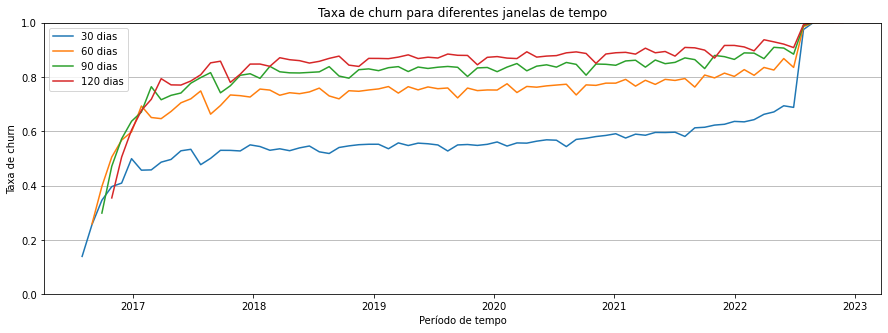

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

def taxa_churn(df, janela_tempo):
    """
    Função que calcula a taxa de churn para cada período de tempo
    considerando uma janela de tempo de 'janela_tempo' dias.
    """
    # cria uma cópia do dataframe original
    df_temp = df.copy()
    
    # adiciona a coluna de data limite (data_cadastro + janela_tempo)
    df_temp['data_limite'] = df_temp['created_at'] + pd.Timedelta(days=janela_tempo)
    
    # adiciona a coluna de churn (1 se data_ultima_compra > data_limite, 0 caso contrário)
    df_temp['churn'] = (df_temp['next_purchase'] <= df_temp['data_limite']).astype(int)
    
    # calcula a taxa de churn para cada período de tempo
    taxa_churn = df_temp.groupby(pd.Grouper(key='data_limite', freq='30D'))['churn'].mean()
    
    return taxa_churn

# testando diferentes janelas de tempo
janelas_tempo = [30, 60, 90, 120]

plt.figure(figsize=(15,5))

for janela in janelas_tempo:
    taxa = taxa_churn(df_ret, janela)
    plt.plot(taxa, label=f'{janela} dias')
    
plt.xlabel('Período de tempo')
plt.ylabel('Taxa de churn')
plt.title('Taxa de churn para diferentes janelas de tempo')
plt.legend(loc='upper left')
#plt.xticks(range(len(taxa)), df_ret[['created_at']].strftime('%Y-%m-%d'), rotation=45)
plt.grid(True, axis='y')
plt.ylim(0, 1)
plt.show()

In [40]:
taxa

data_limite
2016-10-28 00:00:00+00:00    0.219512
2016-11-04 00:00:00+00:00    0.323077
2016-11-11 00:00:00+00:00    0.435484
2016-11-18 00:00:00+00:00    0.383562
2016-11-25 00:00:00+00:00    0.416667
                               ...   
2022-10-28 00:00:00+00:00    1.000000
2022-11-04 00:00:00+00:00    1.000000
2022-11-11 00:00:00+00:00    1.000000
2022-11-18 00:00:00+00:00    1.000000
2022-11-25 00:00:00+00:00    1.000000
Freq: 7D, Name: churn, Length: 318, dtype: float64

# =====================================

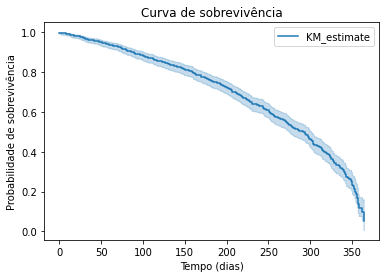

O ponto de inflexão da curva de sobrevivência é 3 dias.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as ll

# Gerando dados de exemplo
n = 1000
observed_times = np.random.randint(0, 365, n)
observed_events = np.random.binomial(1, 0.5, n)
#df = pd.DataFrame({'time': observed_times, 'event': observed_events})
df = pd.DataFrame({'time': observed_times, 'event': observed_events})

# Criação da curva de sobrevivência
kmf = ll.KaplanMeierFitter()
kmf.fit(df['time'], event_observed=df['event'])
kmf.plot()
plt.xlabel('Tempo (dias)')
plt.ylabel('Probabilidade de sobrevivência')
plt.title('Curva de sobrevivência')
plt.show()

# Identificação do ponto de inflexão
slopes = np.diff(kmf.survival_function_.values.squeeze())
change_point = np.argmax(slopes) + 1
print(f'O ponto de inflexão da curva de sobrevivência é {change_point} dias.')

O ponto de inflexão da curva de sobrevivência é 1 dias.


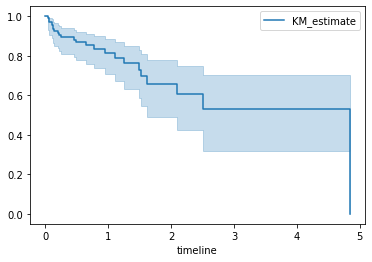

In [23]:
import numpy as np
from lifelines import KaplanMeierFitter

# gerando dados aleatórios
np.random.seed(1234)
dados = np.random.exponential(1, size=100)
censura = np.random.binomial(1, 0.8, size=100)
tempo = np.minimum(dados, 5) # limitando o tempo máximo em 5 unidades

# criando o objeto KaplanMeierFitter e ajustando a curva de sobrevivência
kmf = KaplanMeierFitter()
kmf.fit(tempo, event_observed=(1-censura))
kmf.plot()

# Identificação do ponto de inflexão
slopes = np.diff(kmf.survival_function_.values.squeeze())
change_point = np.argmax(slopes) + 1
print(f'O ponto de inflexão da curva de sobrevivência é {change_point} dias.')

In [26]:
dados

array([0.21259866, 0.97314888, 0.5757691 , 1.53878647, 1.51401778,
       0.31826858, 0.32360533, 1.61884289, 3.17340912, 2.08693059,
       0.44288239, 0.69513941, 1.15031494, 1.24723537, 0.46243356,
       0.82370286, 0.6993326 , 0.01386411, 1.48204177, 2.14251929,
       0.45395074, 0.95554151, 0.07837378, 0.46017054, 2.70515592,
       1.05376745, 0.50617409, 1.55461902, 0.38102051, 0.83955808,
       2.03353087, 0.57300856, 1.62023419, 0.15521254, 1.21827787,
       1.21936163, 0.24691397, 2.58850377, 0.5836486 , 2.40037389,
       0.06167247, 0.2036928 , 0.04851325, 1.12356384, 0.90294217,
       0.7620904 , 0.04429057, 0.82424287, 0.39998283, 0.69909852,
       0.11866453, 0.93443868, 0.8345832 , 0.00678704, 0.96087424,
       2.43181588, 1.56314674, 4.83854922, 3.18935979, 1.57004479,
       0.33582379, 0.98060716, 0.65026739, 0.21775208, 0.48178063,
       0.05537919, 0.60083861, 4.01764697, 0.13232378, 0.12713009,
       1.34140917, 0.88504315, 0.63796328, 0.11331072, 0.26035